In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from bokeh.plotting import figure,show
from bokeh.io import output_notebook
from bokeh.models.tools import HoverTool
from scipy import fft, signal
import colorsys

#- https://stackoverflow.com/a/20627316
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.max_colwidth = 255


### Helper functions

In [2]:
def count_empty_cells(df):
    pd.set_option('display.max_rows', None)
    display(df.shape[0]- df.count())
    pd.set_option('display.max_rows', 10)
    
    
def show_data_types(df):
    pd.set_option('display.max_rows', None)
    display(df.dtypes)
    pd.set_option('display.max_rows', 10)
    
    
def show_all_rows(df):
    pd.set_option('display.max_rows', None)
    display(df)
    pd.set_option('display.max_rows', 10)
    
def show_all_plots(layer1, layer2=False, num_cols=5):
    # This will select all the numeric columns
    numeric_columns = layer1.select_dtypes(include='number').columns

    # Get the number of columns
    num_plots = len(numeric_columns)
    num_rows = math.ceil(num_plots/num_cols)

    fig, axisRows = plt.subplots(num_rows, num_cols, figsize=(20, 4*num_rows))
    i = 0
    for axisCols in axisRows:
        for axis in axisCols:
            if (i<num_plots):
                layer1.hist(column = numeric_columns[i], bins = 10, ax=axis)
                if isinstance(layer2, pd.DataFrame):
                    layer2.hist(column = numeric_columns[i], bins = 10, ax=axis)
            i = i+1
    plt.savefig('Plots\dataset.png')
            
def get_complete_columns(dataFrame, threshold=0.5):
    
    result = dataFrame.count() / dataFrame.shape[0]
    result = pd.DataFrame(result)

    columns = result[result[0] >threshold].index

    return dataFrame[columns]

colors = ['red', 'black', 'green']


def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % tuple([int(x*255) for x in rgb])
    

def hsv_to_hex(hue, sat, val):
    return rgb_to_hex(colorsys.hsv_to_rgb(hue/100, sat/100,  val/100))


def get_color(idx):
    if idx < len(colors):
        return colors[idx]
    else:
        idx -= len(colors)
        return hsv_to_hex(50+idx%4*20, 100-idx%3*20, 50+idx%2*20)
    

def plot_signal(df, column_names):
    output_notebook()
    first_signal = df[column_names[0]]
    default_args = {
            'width': 900, 'height': 300, 
            'x_axis_label': 'time [days since January 1st 2020]', 'y_axis_label': 'value', 
            'y_range': (0, first_signal.max()), 
            'tools': 'xpan,xwheel_zoom,box_zoom,xzoom_in,xzoom_out,save,reset', 
            'active_drag': 'xpan',
            'active_inspect': 'auto',
            'active_scroll': 'auto',
            'toolbar_location': 'above',
    }
    hover_tool = HoverTool(
            tooltips=[('time [s]', '$x{0.000}'), ('amplitude', '$y{0.000}')],
            mode='vline',
    )
    for idx, column_name in enumerate(column_names):
        signal = df[column_name]        
        default_args['y_range'] = (0, signal.max()+1 if idx < 3 else 10)
        default_args['y_axis_label'] = column_name
        fig = figure(**default_args)
        fig.line(range(len(signal)), signal, line_color=get_color(idx), line_width=2, legend_label=column_name, alpha=0.7)
        fig.add_tools(hover_tool)
        show(fig)

### Loading the datasets

In [3]:
covid = pd.DataFrame(pd.read_csv('.\Datasets\owid-covid-data.csv'))
covid = get_complete_columns(covid, 0.1)
covid_spread = covid[['iso_code', 'location' ,'date', 'new_cases', 'new_cases_smoothed', 'new_cases_per_million', 'new_cases_smoothed_per_million', 
                      'new_deaths', 'new_deaths_smoothed', 'new_deaths_per_million', 'new_deaths_smoothed_per_million', 'new_vaccinations_smoothed' , 'new_vaccinations_smoothed_per_million', 'people_fully_vaccinated_per_hundred' , 'population', 'stringency_index']]
covid_spread['people_fully_vaccinated_per_million'] = 0 #(covid_spread['people_fully_vaccinated_per_hundred'] - covid_spread['people_fully_vaccinated_per_hundred'].shift(1)) * 10000
covid_spread.set_index('location', inplace=True)


# Drop countries which have ono cases reported in covid dataset
covid_spread.drop(index=['Turkmenistan', 'Greenland', 'Faeroe Islands', 'Macao',
                         'Aruba', 'Tonga', 'Bermuda', 'Comoros', 'Kiribati',
                         'Solomon Islands', 'Djibouti', 'Tanzania', 'Tajikistan',
                         'Ghana', 'Burundi', 'Burkina Faso', 'Eritrea','Central African Republic',
                         'Cote d\'Ivoire', 'Madagascar', 'Vanuatu', 'Nicaragua', 'Yemen',
                        'Estonia', 'Finland', 'Belarus', 'Taiwan', 'Cambodia', 'Switzerland',
                         'Mali', 'South Korea', 'Singapore', 'Niger', 'Somalia', 'Cameroon', 'Iceland',
                        'Malawi', 'Latvia','Afghanistan', 'Chad', 'Lesotho', 'Ethiopia', 'Mozambique', 'Zambia',
                         'Palestine', 'Papua New Guinea', 'Sierra Leone', 'Libya', 'Sri Lanka', 'Syria', 'United Arab Emirates',
                         'Democratic Republic of Congo' ], inplace=True)

covid_spread.head(5)

,iso_code,date,new_cases,new_cases_smoothed,new_cases_per_million,new_cases_smoothed_per_million,new_deaths,new_deaths_smoothed,new_deaths_per_million,new_deaths_smoothed_per_million,new_vaccinations_smoothed,new_vaccinations_smoothed_per_million,people_fully_vaccinated_per_hundred,population,stringency_index,people_fully_vaccinated_per_million
location,,,,,,,,,,,,,,,,
Africa,OWID_AFR,2020-02-13,0.0,NaN,0.000,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.373486e+09,NaN,0
Africa,OWID_AFR,2020-02-14,1.0,NaN,0.001,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.373486e+09,NaN,0
Africa,OWID_AFR,2020-02-15,0.0,NaN,0.000,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.373486e+09,NaN,0
Africa,OWID_AFR,2020-02-16,0.0,NaN,0.000,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.373486e+09,NaN,0
Africa,OWID_AFR,2020-02-17,0.0,NaN,0.000,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,1.373486e+09,NaN,0


In [4]:
policies = pd.DataFrame(pd.read_csv('.\Datasets\OxCGRT_latest.csv'))
policies.drop(columns=['ConfirmedCases', 'ConfirmedDeaths', 'StringencyIndex', 
                       'StringencyIndexForDisplay', 'StringencyLegacyIndex', 'StringencyLegacyIndexForDisplay', 
                       'GovernmentResponseIndex', 'GovernmentResponseIndexForDisplay', 'ContainmentHealthIndex',
                       'ContainmentHealthIndexForDisplay', 'EconomicSupportIndex', 'EconomicSupportIndexForDisplay'], inplace=True)
policies = policies[policies['RegionName'].isnull()]
policies = get_complete_columns(policies, 0.1)
policies.head(5)

C:\Users\Ariana\.conda\envs\VA\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (2,3) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,CountryName,CountryCode,Jurisdiction,Date,C1_School closing,C1_Flag,C2_Workplace closing,C2_Flag,C3_Cancel public events,C3_Flag,...,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag
0,Aruba,ABW,NAT_TOTAL,20200101,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
1,Aruba,ABW,NAT_TOTAL,20200102,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
2,Aruba,ABW,NAT_TOTAL,20200103,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
3,Aruba,ABW,NAT_TOTAL,20200104,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN
4,Aruba,ABW,NAT_TOTAL,20200105,0.0,NaN,0.0,NaN,0.0,NaN,...,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,0.0,NaN


### Joining the datasets

In [5]:
if 'datetime' not in str(covid_spread.dtypes['date']):
    covid_spread['date'] = pd.to_datetime(covid_spread['date'].str.strip(), format='%Y-%m-%d')

def parse_date(row):
    row['Date'] = datetime.strptime(str(row['Date']), '%Y%m%d')
    return row

if 'datetime' not in str(policies.dtypes['Date']):
    policies = policies.apply(parse_date, axis='columns')

    
print('%s, %s' % (covid_spread.dtypes['date'], policies.dtypes['Date']))

dataset = pd.merge(covid_spread.reset_index(), policies, left_on=['iso_code', 'date'], right_on=['CountryCode','Date'], how='inner', copy=False)
dataset.drop(columns=['CountryCode','Date'], inplace=True)
dataset.set_index('location', inplace=True)

datetime64[ns], datetime64[ns]


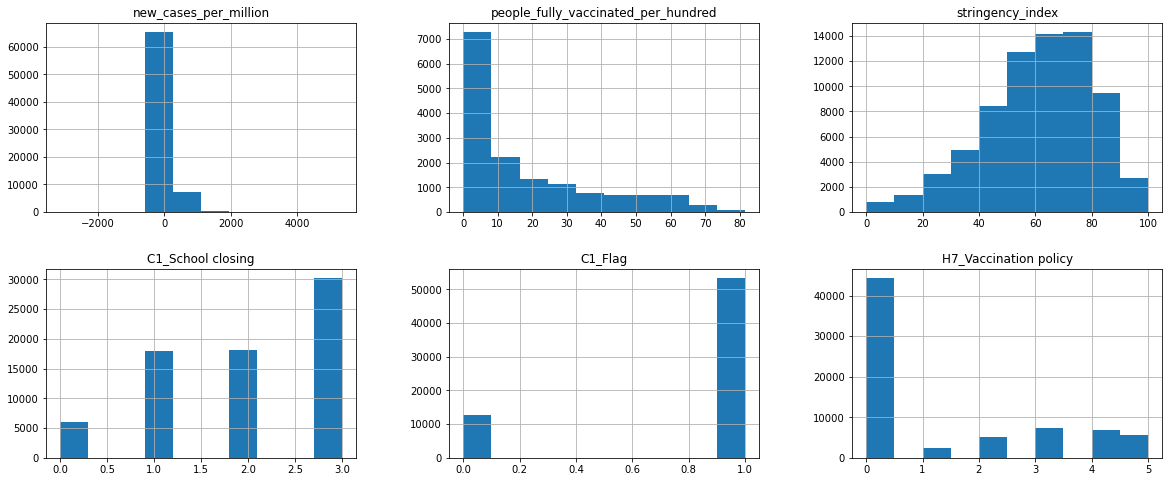

In [6]:
show_all_plots(dataset[['new_cases_per_million', 'people_fully_vaccinated_per_hundred', 'stringency_index', 'C1_School closing', 'C1_Flag', 'H7_Vaccination policy']], num_cols=3)

### Fill missing values with nearest value for each country individually

In [7]:
dataset_per_country = dataset.reset_index().set_index(['location', 'date']).unstack('location')

def nearest(column):
    column = column.interpolate(method='nearest', limit_direction='forward', fill_value='extrapolate')
    column = column.interpolate(method='nearest', limit_direction='backward', fill_value='extrapolate')
    return column

dataset_per_country = dataset_per_country.apply(nearest)
dataset_signals = dataset_per_country.stack(-1).reset_index().set_index('location')

#save processed dataset into a csv
dataset_signals.to_csv('.\Datasets\dataset_signals.csv')


#count_empty_cells(dataset_signals)
dataset_signals.head(5)

,date,iso_code,new_cases,new_cases_smoothed,new_cases_per_million,new_cases_smoothed_per_million,new_deaths,new_deaths_smoothed,new_deaths_per_million,new_deaths_smoothed_per_million,...,H2_Testing policy,H3_Contact tracing,H4_Emergency investment in healthcare,H5_Investment in vaccines,H6_Facial Coverings,H6_Flag,H7_Vaccination policy,H7_Flag,H8_Protection of elderly people,H8_Flag
location,,,,,,,,,,,,,,,,,,,,,
Albania,2020-01-01,NaN,2.0,5.429,0.696,1.890,1.0,0.143,0.348,0.050,...,0.0,0.0,1000000.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0
Algeria,2020-01-01,NaN,1.0,0.143,0.022,0.003,1.0,0.000,0.022,0.000,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
Andorra,2020-01-01,NaN,1.0,0.143,12.928,1.847,1.0,0.000,12.928,0.000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Angola,2020-01-01,NaN,1.0,0.429,0.029,0.013,2.0,0.000,0.059,0.000,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
Argentina,2020-01-01,ARG,1.0,1.714,0.022,0.038,1.0,0.143,0.022,0.003,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


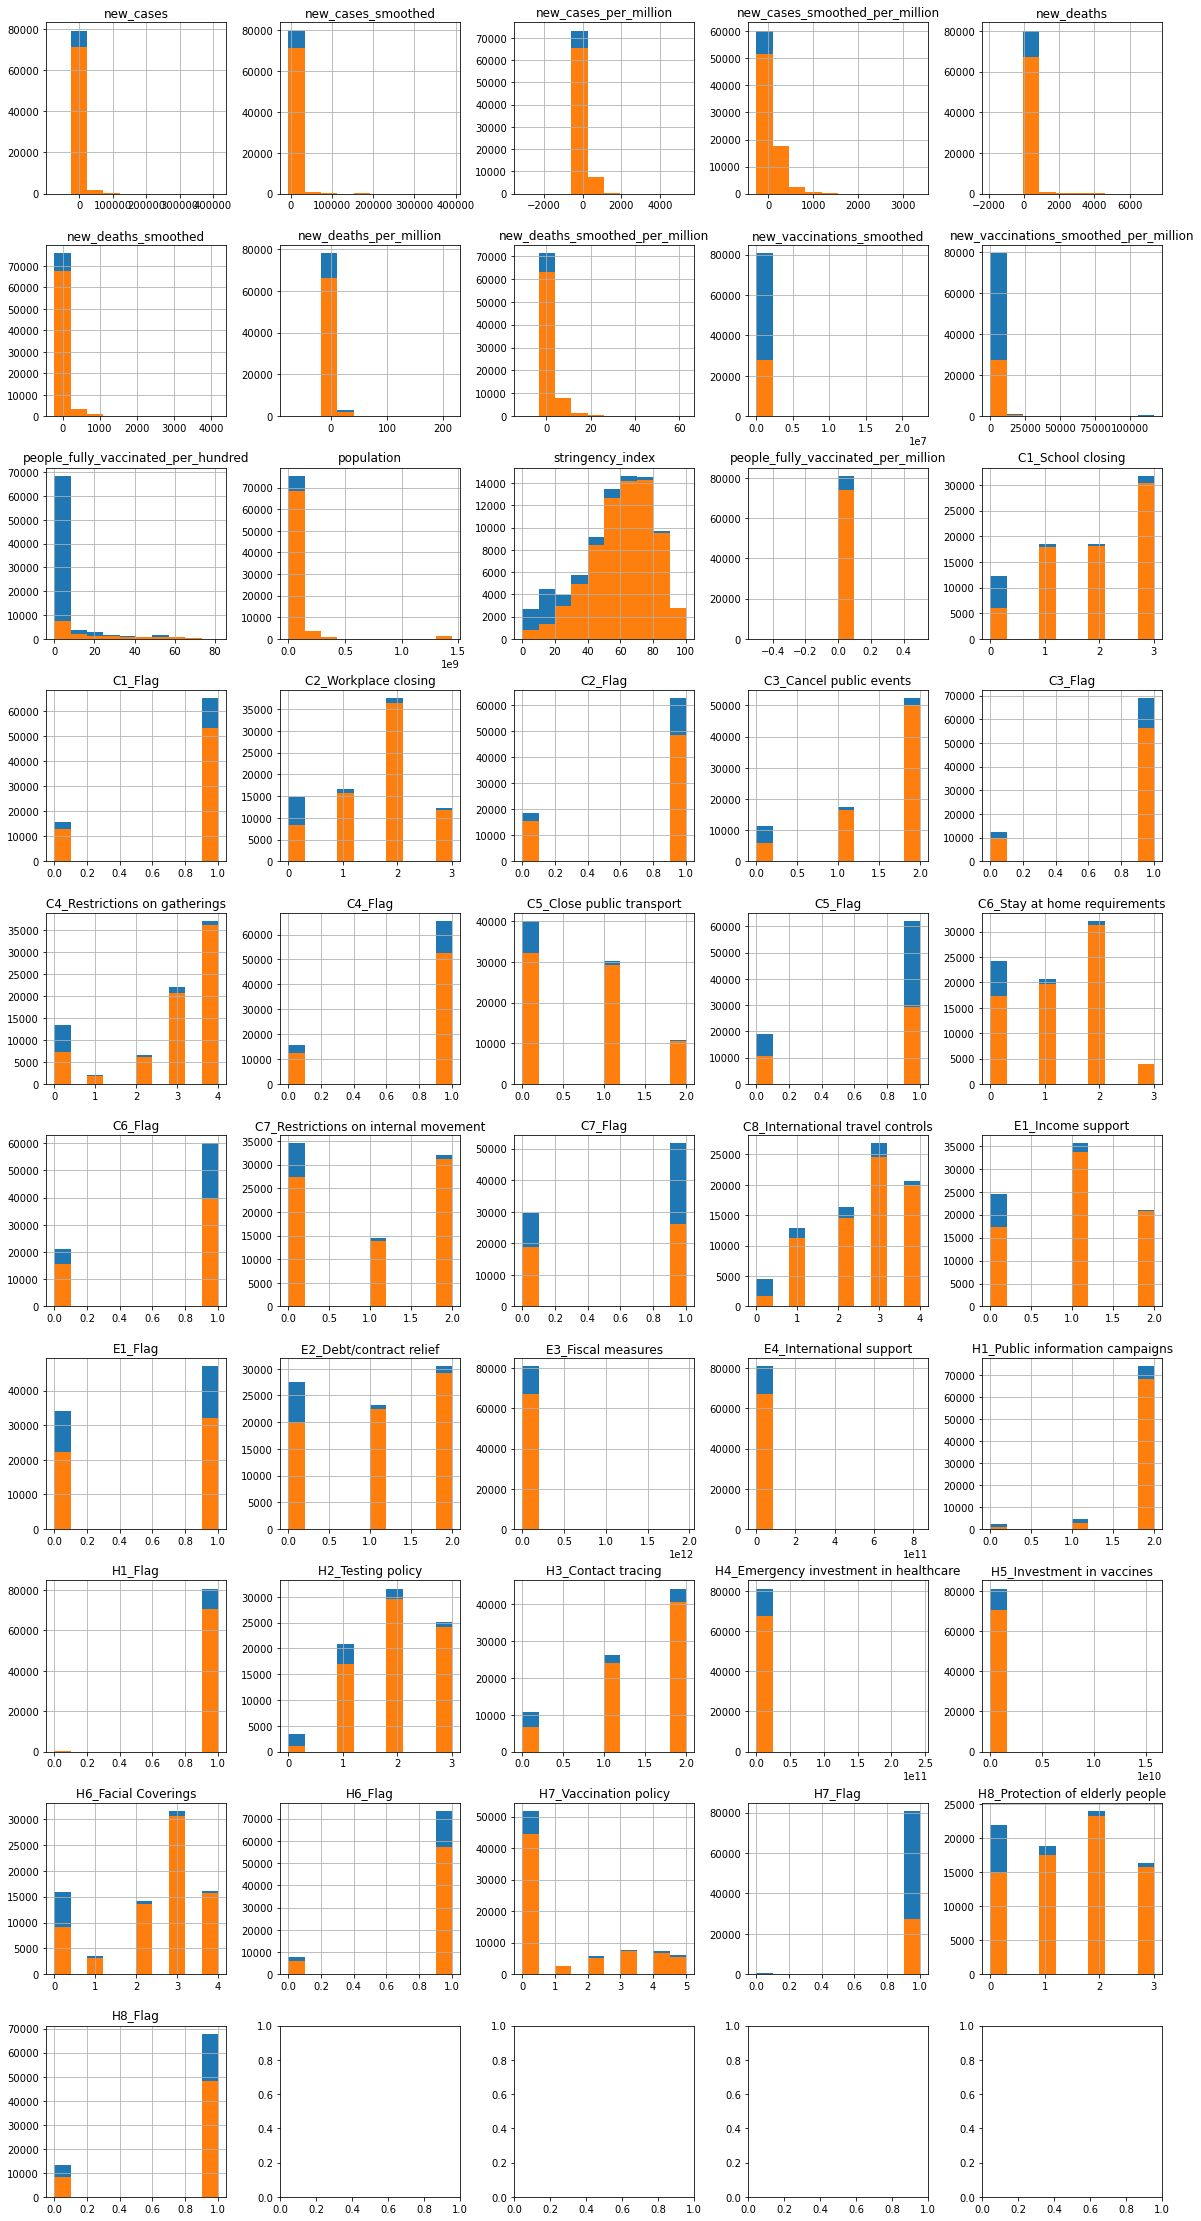

In [8]:
#columns = ['new_cases_per_million', 'people_fully_vaccinated_per_hundred', 'stringency_index', 'C1_School closing', 'C1_Flag', 'H7_Vaccination policy']
columns = dataset.columns
show_all_plots(dataset_signals[columns], dataset[columns], num_cols=5)

### Distribution of cases, deaths, vaccinations and policies over time in Cuba

In [9]:
cuba = dataset_signals.loc[['Cuba']]
plot_signal(cuba, ['new_cases_smoothed_per_million', 'new_deaths_smoothed_per_million', 'people_fully_vaccinated_per_hundred', 'C3_Cancel public events', 'C3_Flag', 'C4_Flag'])

Loading BokehJS ...

### Cross-correlation
#### Computing signal cross-correlation between new_cases_per_million_smoothed and each preventive measure in every country

In [10]:
def signal_energy(signal):
    return np.square(signal).sum()


def correlation_coeff(signal1, signal2):
    signal1 = signal1 - np.mean(signal1)
    signal2 = signal2 - np.mean(signal2)
    return signal.correlate(signal1, signal2, mode='full') / (math.sqrt(signal_energy(signal1)*signal_energy(signal2)) or 1)


In [19]:
country_names = dataset_signals.reset_index().groupby(by='location', as_index=False).agg('first')['location']
column_names = ['location','corr_coeff_min', 'negative_correlation_time_delay', 'corr_coeff_max','positive_correlation_time_delay','signal_length']

def correlate_columns_per_country(dataset, column1, column2):
    correlations = []
    for country_name in country_names:
        country_data = dataset.loc[[country_name]]
        signal_length = country_data.shape[0]
        corr_coeffs = [x for x in correlation_coeff(country_data[column1], country_data[column2])]
        min_coeff = min(corr_coeffs[signal_length:])
        max_coeff = max(corr_coeffs[0:signal_length])
        idx_max_coeff = corr_coeffs.index(max_coeff)
        idx_min_coeff = corr_coeffs.index(min_coeff, signal_length)
        row = pd.DataFrame([[country_name, min_coeff, idx_min_coeff, max_coeff, idx_max_coeff, signal_length]], columns=column_names)
        correlations.append(row)
    correlations = pd.concat(correlations).set_index('location')
    correlations['positive_correlation_time_delay'] = correlations['positive_correlation_time_delay'] - correlations['signal_length']
    correlations['negative_correlation_time_delay'] = correlations['negative_correlation_time_delay'] - correlations['signal_length']
    correlations['column_name'] = column2
    return correlations


#### Calculating correlations for new_cases_per_million and each lockdown measure

In [12]:
correlations = []

for column in (set(policies.select_dtypes(include='float64').columns) | {'stringency_index'}):
    correlations.append(correlate_columns_per_country(dataset_signals, 'new_cases_per_million', column))

correlations = pd.concat(correlations)
correlations.sort_values(by='corr_coeff_min').to_csv('Datasets\correlations.csv')
show_all_rows(correlations[correlations['negative_correlation_time_delay'] >= 0].sort_values(by='corr_coeff_min').shape[0])

4290

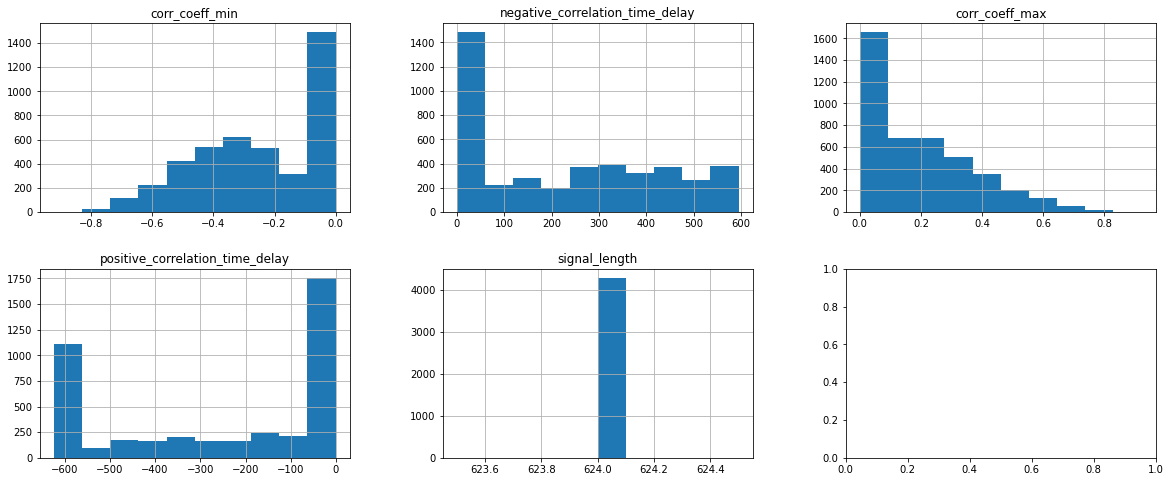

In [13]:
show_all_plots(correlations, num_cols=3)

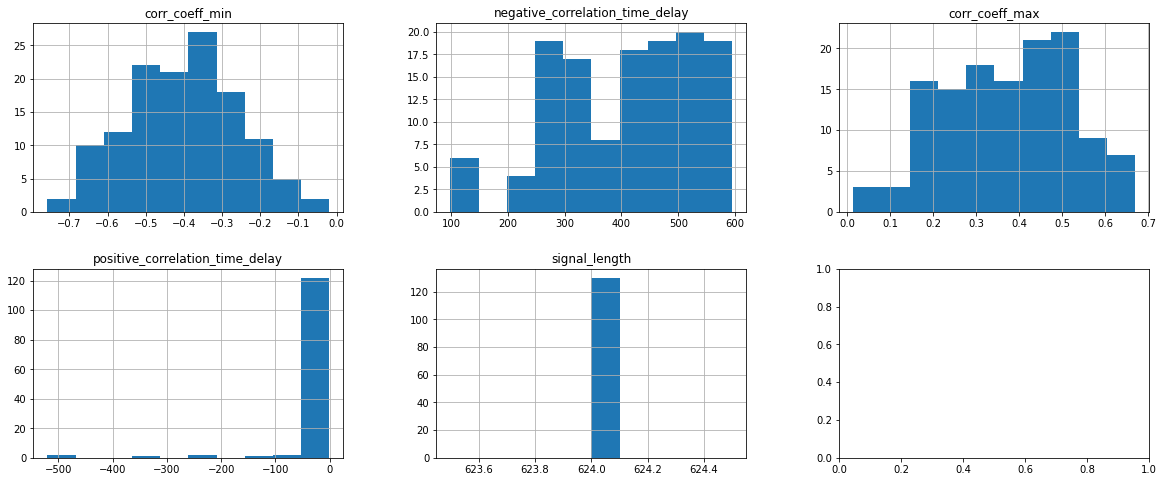

In [14]:
show_all_plots(correlations[correlations['column_name'] == 'H6_Facial Coverings'], num_cols=3)

#### Showing the strongest inverse correlations

In [15]:
show_all_rows(correlations.sort_values(by='corr_coeff_min').head(5))

,corr_coeff_min,negative_correlation_time_delay,corr_coeff_max,positive_correlation_time_delay,signal_length,column_name
location,,,,,,
Cuba,-0.922891,0,0.170623,-539,624,C3_Flag
Fiji,-0.833269,28,0.097382,-511,624,H6_Flag
Cuba,-0.824516,544,0.188515,-1,624,C3_Cancel public events
Australia,-0.821778,590,0.095952,-1,624,H1_Public information campaigns
Cuba,-0.813772,0,0.192199,-507,624,C4_Flag


#### Showing the strongest positive correlations

In [16]:
show_all_rows(correlations.sort_values(by='corr_coeff_max', ascending=False).head(5))

,corr_coeff_min,negative_correlation_time_delay,corr_coeff_max,positive_correlation_time_delay,signal_length,column_name
location,,,,,,
Thailand,-0.151917,497,0.921563,-1,624,H7_Vaccination policy
Paraguay,-0.195187,327,0.849942,-74,624,H7_Vaccination policy
Uruguay,-0.197513,369,0.823935,-77,624,H7_Vaccination policy
Lebanon,-0.207306,266,0.805665,-158,624,H7_Vaccination policy
Malaysia,-0.281932,489,0.803587,-1,624,C5_Close public transport


#### Showing the most effective restriction over all countries

In [20]:
most_effective_measure = correlations.groupby(by='column_name').agg('median').sort_values('corr_coeff_min')[['corr_coeff_min', 'negative_correlation_time_delay']]
#most_effective_measure.to_csv('Datasets\correlations_agg1.csv')
most_effective_measure.head(10)

,corr_coeff_min,negative_correlation_time_delay
column_name,,
H6_Facial Coverings,-0.410091,432.5
stringency_index,-0.401829,419.0
C4_Restrictions on gatherings,-0.395941,397.0
C3_Cancel public events,-0.378362,370.0
H8_Protection of elderly people,-0.369662,363.0
E1_Income support,-0.366303,366.5
C2_Workplace closing,-0.362278,383.5
C8_International travel controls,-0.357756,317.5
H2_Testing policy,-0.357335,363.0


#### Showing the policies which were adapted as a response of the changes in the number of cases

In [18]:
measures_determined_by_cases = correlations.groupby(by='column_name').agg('median').sort_values('corr_coeff_max', ascending=False)[['corr_coeff_max', 'positive_correlation_time_delay']]
#measures_determined_by_cases.to_csv('Datasets\correlations_agg2.csv')
measures_determined_by_cases

,corr_coeff_max,positive_correlation_time_delay
column_name,,
H7_Vaccination policy,0.526739,-73.0
H6_Facial Coverings,0.393208,-1.0
H2_Testing policy,0.350519,-4.5
C4_Restrictions on gatherings,0.303195,-1.0
C6_Stay at home requirements,0.301418,-6.5
...,...,...
E1_Flag,0.000000,-624.0
H5_Investment in vaccines,0.000000,-624.0
H6_Flag,0.000000,-624.0
